# Premiers pas en *pandas*

***
> __Auteur__: Joseph Salmon
> <joseph.salmon@umontpellier.fr>

<a id="sommaire"> </a>
## Sommaire

*  __[Introduction et présentation](#intro)__ <br>
*  __[Données Airparif](#airparif)__ <br>
*  __[Données EDF](#edf)__ <br>
*  __[Ajout de données climatiques](#clima)__ <br>

<a id="intro"> </a>

# Introduction et présentation
Dans ce TP on va apprendre à manipuler des données temporelles. On s'intéressera à deux cas:
- une base de données sur la pollution atmosphériques
- une base de données sur la consomation électriqures d'un ménage.

<a id="airparif"> </a>

# Étude de la qualité de l'air sur Paris (13eme)

Source: Airparif

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from download import download
pd.options.display.max_rows = 8

# For new versions of pandas:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# Download
url = "http://josephsalmon.eu/enseignement/datasets/20080421_20160927-PA13_auto.csv"
path_target = "./20080421_20160927-PA13_auto.csv"
download(url, path_target, replace=False)

Replace is False and data exists, so doing nothing. Use replace==True to re-download the data.


'./20080421_20160927-PA13_auto.csv'

In [3]:
pollution_df = pd.read_csv('20080421_20160927-PA13_auto.csv', sep=';',
                           comment='#', na_values="n/d",
                           converters={'heure': str})
pollution_df.head(24)

,date,heure,NO2,O3
0,21/04/2008,1,13.0,74.0
1,21/04/2008,2,11.0,73.0
2,21/04/2008,3,13.0,64.0
3,21/04/2008,4,23.0,46.0
...,...,...,...,...
20,21/04/2008,21,39.0,40.0
21,21/04/2008,22,31.0,42.0
22,21/04/2008,23,29.0,42.0
23,21/04/2008,24,28.0,36.0


In [4]:
# Question transformée les heures:

In [5]:
# 24:00 issues, voir https://www.tutorialspoint.com/python/time_strptime.htm
# pollution_df['heure'] = pollution_df['heure'].replace('24', '0')
pollution_df['heure'] = pollution_df['heure'].astype(int) - 1
pollution_df['heure'] = pollution_df['heure'].astype(str)

In [6]:
time_improved = pd.to_datetime(pollution_df['date'] +
                               ' ' + pollution_df['heure'] + ':00',
                               format='%d/%m/%Y %H:%M')

pollution_df['DateTime'] = time_improved
del pollution_df['heure']
del pollution_df['date']


pollution_ts = pollution_df.set_index(['DateTime'])
pollution_ts = pollution_ts.sort_index()


# Seulement les 4 années pleines
day_ini = '01/01/2009'
day_end = '12/31/2015'
pollution_ts = pollution_ts.loc[day_ini:day_end]


pollution_ts.head()

,NO2,O3
DateTime,,
2009-01-01 00:00:00,56.0,0.0
2009-01-01 01:00:00,57.0,0.0
2009-01-01 02:00:00,54.0,3.0
2009-01-01 03:00:00,60.0,0.0
2009-01-01 04:00:00,66.0,0.0


In [7]:
pollution_ts.describe()

,NO2,O3
count,58729.000000,59476.000000
mean,35.169865,39.009886
std,20.708880,28.899521
min,1.000000,0.000000
25%,19.000000,15.000000
50%,31.000000,37.000000
75%,47.000000,57.000000
max,167.000000,203.000000


In [8]:
pollution_ts.shape

(61296, 2)

<IPython.core.display.Javascript object>


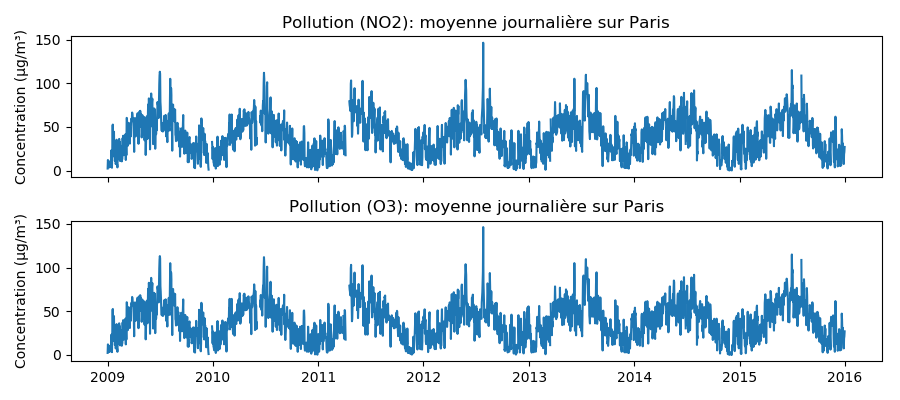

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(9, 4), sharex=True)
names_polluant = ['NO2', 'O3']
for i, polluant in enumerate(names_polluant):
    axes[i].plot(pollution_ts['O3'].resample('D').mean())
    axes[i].set_title(
        "Pollution ({}): moyenne journalière sur Paris".format(polluant))
    axes[i].set_ylabel("Concentration (µg/m³)")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


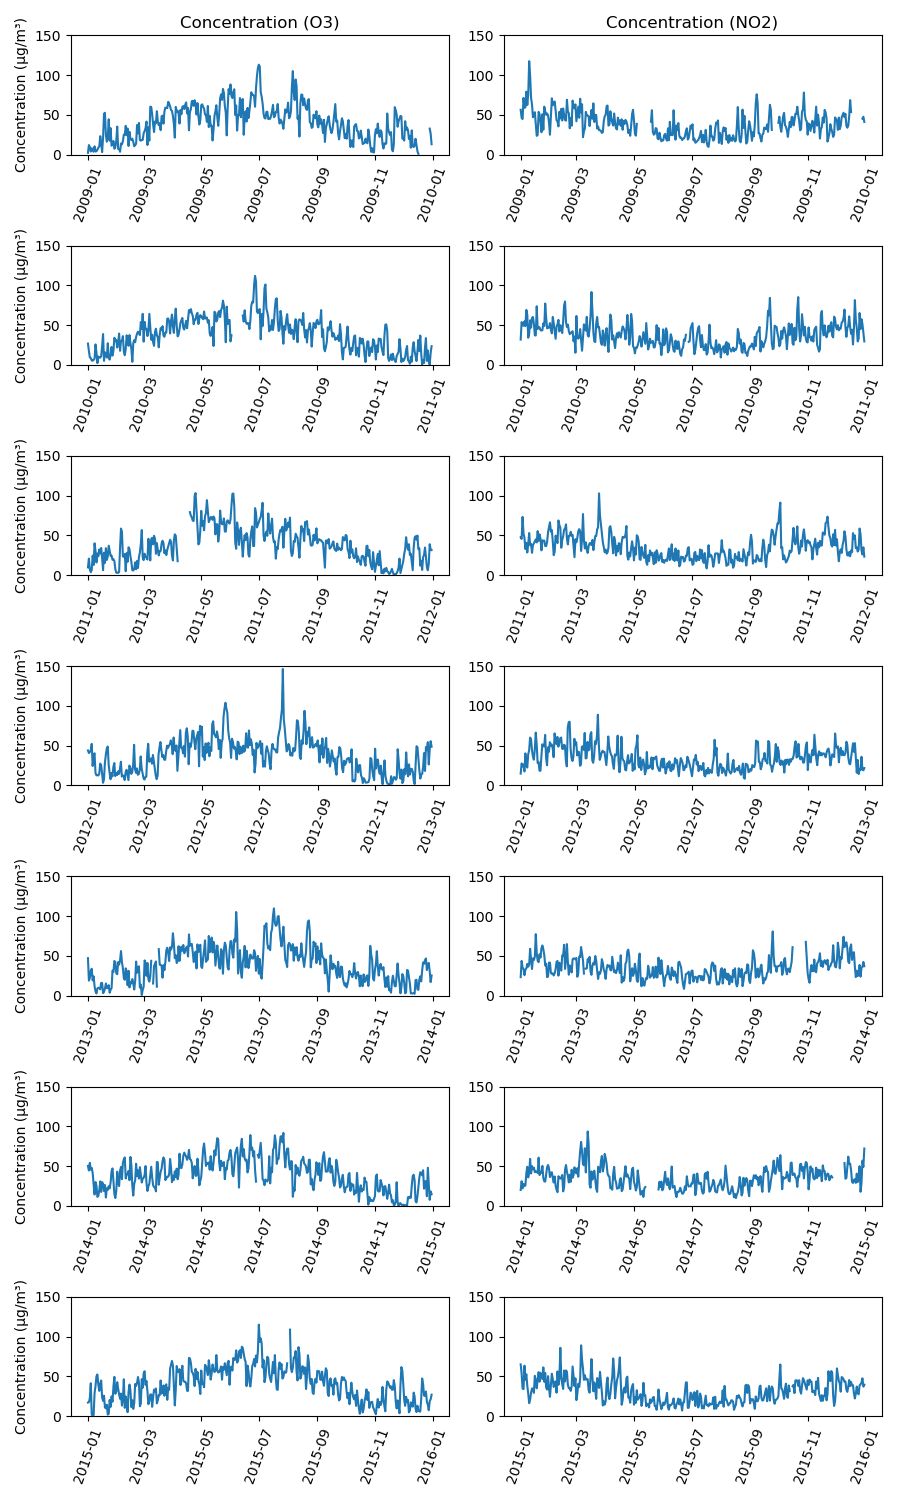

In [10]:
years = ['2009', '2010', '2011', '2012', '2013', '2014', '2015']
fig_fix1, axs = plt.subplots(len(years), 2, figsize=(9, 15))
axs = axs.ravel()
ts_years = []
for i, year in enumerate(years):
    day_ini = '01/01/' + year
    day_end = '31/12/' + year
    ts_year = pollution_ts.loc[day_ini:day_end]
    ts_year_day = ts_year.groupby(ts_year.index.date).mean()
    ts_years.append(ts_year_day)
    axs[2*i].plot(ts_year_day['O3'])
    axs[2*i].set_ylim(0, 150)
    axs[2*i].set_ylabel("Concentration (µg/m³)")
    plt.setp(axs[2*i].xaxis.get_majorticklabels(), rotation=70)

    axs[2*i + 1].plot(ts_year_day['NO2'])
    axs[2*i + 1].set_ylim(0, 150)
    plt.setp(axs[2*i + 1].xaxis.get_majorticklabels(), rotation=70)
axs[0].set_title("Concentration (O3)")
axs[1].set_title("Concentration (NO2)")

plt.tight_layout()
plt.show()

La pollution atmosphérique montre-t-elle une tendance à la baisse au fil des ans?

<IPython.core.display.Javascript object>


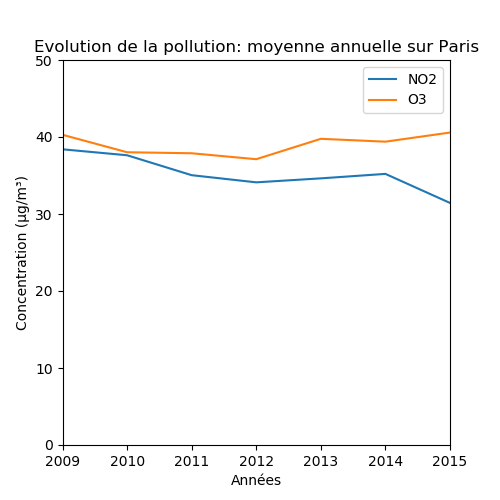

Text(0.5, 0, 'Années')

In [11]:
ax = pollution_ts['2008':].resample('A').mean().plot(figsize=(5,5))  # échantillone par année (A pour Annual)
plt.ylim(0,50)
plt.title("Evolution de la pollution: moyenne annuelle sur Paris")
plt.ylabel("Concentration (µg/m³)")
plt.xlabel("Années")

In [12]:
sns.set_palette("GnBu_d", n_colors=9)

<IPython.core.display.Javascript object>


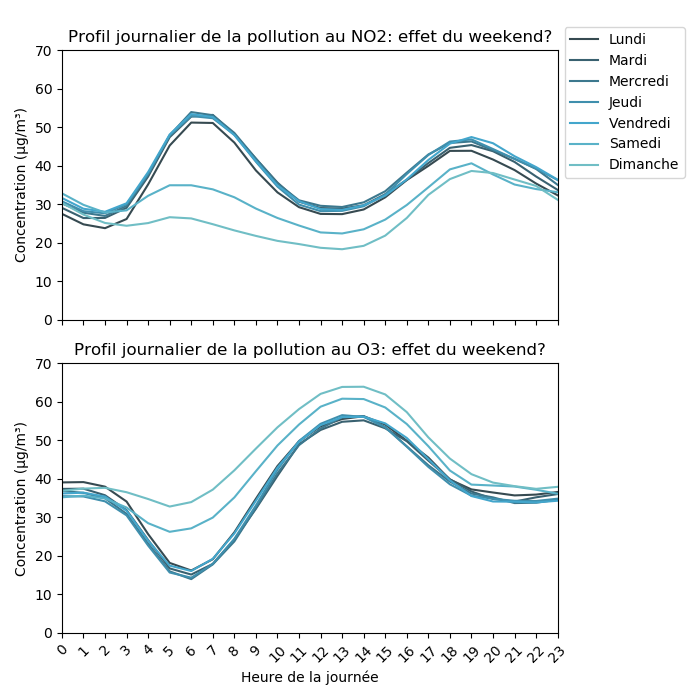

In [13]:
pollution_ts['weekday'] = pollution_ts.index.weekday  # Monday=0, Sunday=6
days = ['Lundi', 'Mardi', 'Mercredi',
        'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']

pollution_week_no2 = pollution_ts.groupby(['weekday', pollution_ts.index.hour])[
    'NO2'].mean().unstack(level=0)
pollution_week_03 = pollution_ts.groupby(['weekday', pollution_ts.index.hour])[
    'O3'].mean().unstack(level=0)

list_polluant_week = [pollution_week_no2, pollution_week_03]

fig, axes = plt.subplots(2, 1, figsize=(7, 7), sharex=True)

for i, polluant in enumerate(names_polluant):
    list_polluant_week[i].plot(ax=axes[i])
    axes[i].set_ylabel("Concentration (µg/m³)")
    axes[i].set_xlabel("Heure de la journée")
    axes[i].set_title(
        "Profil journalier de la pollution au {}: effet du weekend?".format(polluant))
    axes[i].set_xticks(np.arange(0, 24))
    axes[i].set_xticklabels(np.arange(0, 24), rotation=45)
    axes[i].set_ylim(0, 70)

axes[1].legend().set_visible(False)

axes[0].legend(labels=days, loc='lower left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

<IPython.core.display.Javascript object>


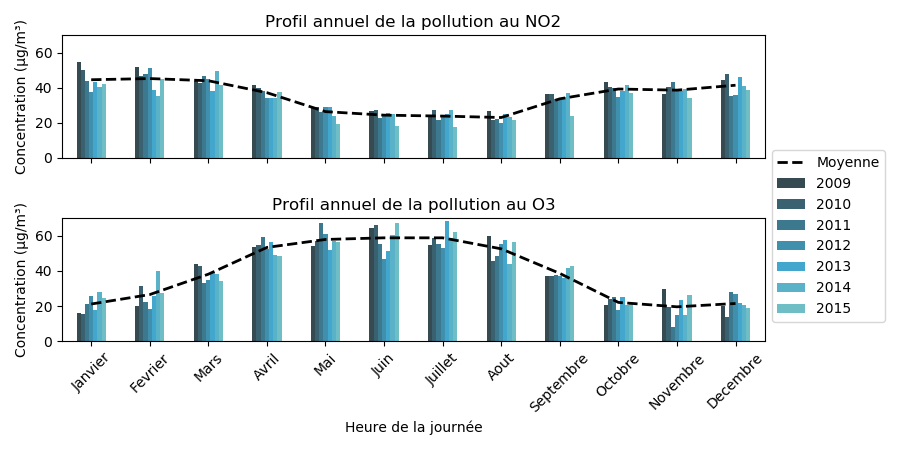

In [14]:
pollution_ts['year'] = pollution_ts.index.year
months = ['Janvier', 'Fevrier', 'Mars', 'Avril', 'Mai', 'Juin',
          'Juillet', 'Aout', 'Septembre', 'Octobre', 'Novembre', 'Decembre']

pollution_year_no2 = pollution_ts.groupby(['year', pollution_ts.index.month])[
    'NO2'].mean().unstack(level=0)
pollution_year_03 = pollution_ts.groupby(['year', pollution_ts.index.month])[
    'O3'].mean().unstack(level=0)

list_polluant = [pollution_year_no2, pollution_year_03]

fig, axes = plt.subplots(2, 1, figsize=(9, 4.5), sharex=True)
for i, polluant in enumerate(names_polluant):
    list_polluant[i].plot(kind='bar', ax=axes[i])
    axes[i].plot(np.arange(0, 12), list_polluant[i].mean(
        axis=1), '--k', label='Moyenne', linewidth=2)
    axes[i].set_ylabel("Concentration (µg/m³)")
    axes[i].set_xlabel("Heure de la journée")
    axes[i].set_title("Profil annuel de la pollution au {}".format(polluant))
    axes[i].set_xticks(np.arange(0, 12))
    axes[i].set_xticklabels(months, rotation=45)
    axes[i].set_ylim(0, 70)

axes[0].legend().set_visible(False)
axes[1].legend(loc='lower left', bbox_to_anchor=(1, 0.1))
plt.tight_layout()
# useful to create pdf for the teacher
# fig.savefig("./prebuiltimages/bars_pollution_year.pdf")

## Question: pics, record et seuils d'alerte.

Seuil légaux: https://www.airparif.asso.fr/reglementation/normes-europeennes
400 µg/m³ en moyenne horaire sur 3 heures consécutives (NO2)

In [15]:
ma_3h = pollution_ts['NO2'].rolling('3H').mean()

In [16]:
ma_3h

DateTime
2009-01-01 00:00:00    56.000000
2009-01-01 01:00:00    56.500000
2009-01-01 02:00:00    55.666667
2009-01-01 03:00:00    57.000000
                         ...    
2015-12-31 20:00:00    65.666667
2015-12-31 21:00:00    55.666667
2015-12-31 22:00:00    45.666667
2015-12-31 23:00:00    33.666667
Name: NO2, Length: 61296, dtype: float64

In [17]:
ma_3h[ma_3h>400] # seuil d'alerte jamais dépassé

Series([], Name: NO2, dtype: float64)

In [18]:
ma_3h.max()

164.66666666666666

## Pics records, top 10

In [19]:
pollution_ts['NO2'].sort_values(ascending=False)[:10] #,polution_ts['NO2'].idxmax()

DateTime
2009-01-10 14:00:00    167.0
2009-01-10 12:00:00    166.0
2009-01-10 13:00:00    161.0
2011-10-03 08:00:00    160.0
                       ...  
2010-04-24 21:00:00    153.0
2009-01-10 23:00:00    152.0
2012-02-22 08:00:00    150.0
2010-04-24 23:00:00    149.0
Name: NO2, Length: 10, dtype: float64

In [20]:
pollution_ts['O3'].sort_values(ascending=False)[:10]

DateTime
2012-07-26 16:00:00    203.0
2012-07-26 15:00:00    201.0
2012-07-26 14:00:00    198.0
2012-07-26 13:00:00    198.0
                       ...  
2012-07-26 17:00:00    189.0
2012-08-18 12:00:00    189.0
2009-07-02 16:00:00    186.0
2015-07-01 13:00:00    185.0
Name: O3, Length: 10, dtype: float64

## Seuil d'information

In [21]:
pd.options.display.max_rows = 20
pics = pollution_ts[pollution_ts['O3'] > 180]
pics

,NO2,O3,weekday,year
DateTime,,,,
2009-07-02 14:00:00,20.0,184.0,3,2009
2009-07-02 15:00:00,28.0,185.0,3,2009
2009-07-02 16:00:00,33.0,186.0,3,2009
2010-07-08 15:00:00,16.0,182.0,3,2010
2012-07-25 15:00:00,24.0,181.0,2,2012
2012-07-25 16:00:00,25.0,183.0,2,2012
2012-07-26 11:00:00,21.0,190.0,3,2012
2012-07-26 12:00:00,18.0,198.0,3,2012
2012-07-26 13:00:00,19.0,198.0,3,2012


In [22]:
# Nombre de jours au dessus du seuil d'information:
np.shape(pics.groupby(pics.index.date))[0]

7

<a id="edf"> </a>

# Consommation d'électricité d'un ménage français (EDF):
Source et descriptif: https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

## Download, décompression et aperçu des données 

In [23]:
# download part if needed.
from download import download
import os
import zipfile

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/'
# Lien alternatif:
# url=http://josephsalmon.eu/enseignement/datasets/household_power_consumption.zip

filename = 'household_power_consumption.zip'
cwd = os.getcwd()
path_target = os.path.join(cwd, filename)
download(url, path_target, replace=False)

# # unzip part
zip = zipfile.ZipFile(path_target)
zip.extractall()

# Visualisation succinte du fichier décompressé:
!head -10 'household_power_consumption.txt' 

Replace is False and data exists, so doing nothing. Use replace==True to re-download the data.
Date;Time;Global_active_power;Global_reactive_power;Voltage;Global_intensity;Sub_metering_1;Sub_metering_2;Sub_metering_3
16/12/2006;17:24:00;4.216;0.418;234.840;18.400;0.000;1.000;17.000
16/12/2006;17:25:00;5.360;0.436;233.630;23.000;0.000;1.000;16.000
16/12/2006;17:26:00;5.374;0.498;233.290;23.000;0.000;2.000;17.000
16/12/2006;17:27:00;5.388;0.502;233.740;23.000;0.000;1.000;17.000
16/12/2006;17:28:00;3.666;0.528;235.680;15.800;0.000;1.000;17.000
16/12/2006;17:29:00;3.520;0.522;235.020;15.000;0.000;2.000;17.000
16/12/2006;17:30:00;3.702;0.520;235.090;15.800;0.000;1.000;17.000
16/12/2006;17:31:00;3.700;0.520;235.220;15.800;0.000;1.000;17.000
16/12/2006;17:32:00;3.668;0.510;233.990;15.800;0.000;1.000;17.000


Nature des données:
Consommation globale du foyer. On regardera surtout *Global_active_power* (puissance active, en kilowatt) dans ce qui suit. 

## Lecture du CSV, identification des valeurs manquantes, et 

In [24]:
na_values = ['?', '']
fields = ['Date', 'Time', 'Global_active_power']

df_conso = pd.read_csv('household_power_consumption' + '.txt', sep=';',
                       na_values=na_values, usecols=fields)
# df_conso = pd.read_csv('household_power_consumption' + '.txt', sep=';', nrows=200000,
#                  na_values=na_values, usecols=fields)

In [25]:
df_conso.head() # Début de la base

,Date,Time,Global_active_power
0,16/12/2006,17:24:00,4.216
1,16/12/2006,17:25:00,5.360
2,16/12/2006,17:26:00,5.374
3,16/12/2006,17:27:00,5.388
4,16/12/2006,17:28:00,3.666


In [26]:
df_conso.tail()  # fin de la base de données

,Date,Time,Global_active_power
2075254,26/11/2010,20:58:00,0.946
2075255,26/11/2010,20:59:00,0.944
2075256,26/11/2010,21:00:00,0.938
2075257,26/11/2010,21:01:00,0.934
2075258,26/11/2010,21:02:00,0.932


In [27]:
df_conso.describe()

,Global_active_power
count,2.049280e+06
mean,1.091615e+00
std,1.057294e+00
min,7.600000e-02
25%,3.080000e-01
50%,6.020000e-01
75%,1.528000e+00
max,1.112200e+01


Dates: l'étude se déroulle de décembre 2006 à novembre 2010

## Détecter et compter les lignes avec des valeurs manquantes.

In [28]:
df_conso.count()

Date                   2075259
Time                   2075259
Global_active_power    2049280
dtype: int64

In [29]:
nb_valeurs_tot = df_conso.count()[0]
nb_valeurs_manquantes = df_conso.count()[2]

ratio_na = (nb_valeurs_tot-nb_valeurs_manquantes) / nb_valeurs_tot
print("La proportion de valeurs manquantes est {:.2f}%".format(ratio_na * 100))

null_data = df_conso[df_conso.isnull().any(axis=1)]

print("Il y a " + str(df_conso.isnull().sum().sum()) + ' lignes manquantes en tout')
print("Il y a " + str(null_data.shape[0]) + ' lignes manquantes en tout')

La proportion de valeurs manquantes est 1.25%
Il y a 25979 lignes manquantes en tout
Il y a 25979 lignes manquantes en tout


In [30]:
# check example mentioned on the webpage:
print(df_conso.iloc[190500])

Date                   28/4/2007
Time                    00:24:00
Global_active_power          NaN
Name: 190500, dtype: object


## Suppression des valeurs manquantes:


In [31]:
df_conso = df_conso.dropna(axis=0)

print('Taille da la base avec valeurs manquantes: {} lignes'.format(
    nb_valeurs_tot))
print('Taille da la base sans valeurs manquantes: {} lignes'.format(
    df_conso.shape[0]))

Taille da la base avec valeurs manquantes: 2075259 lignes
Taille da la base sans valeurs manquantes: 2049280 lignes


## Indexation temporelle

In [32]:
# Using infer_datetime_format=True below helps for speed issues
time_improved = pd.to_datetime(df_conso['Date'] + ' ' + df_conso['Time'], dayfirst=True,
                               infer_datetime_format=True)

df_conso['DateTime'] = time_improved
del df_conso['Date']
del df_conso['Time']
ts_conso = df_conso.set_index(['DateTime'])

# Seulement les 4 années pleines
day_ini = '01/01/2007'
day_end = '12/31/2010'
ts_conso = ts_conso.loc[day_ini:day_end]

ts_conso.head()

,Global_active_power
DateTime,
2007-01-01 00:00:00,2.580
2007-01-01 00:01:00,2.552
2007-01-01 00:02:00,2.550
2007-01-01 00:03:00,2.550
2007-01-01 00:04:00,2.554


# Affichage graphique

<IPython.core.display.Javascript object>


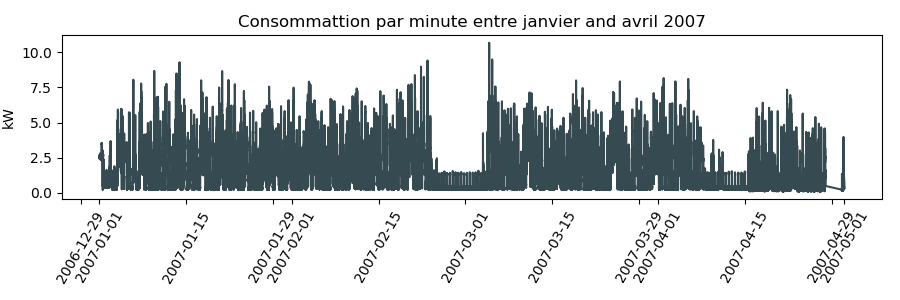

In [33]:
fig_2007 = plt.figure(figsize=(9, 3))
day_ini_2007 = '01/01/2007'
day_end_2007 = '04/30/2007'
ts_2007 = ts_conso.loc[day_ini_2007:day_end_2007]
plt.plot(ts_2007['Global_active_power'])
plt.xticks(rotation=60)
plt.ylabel('kW')
plt.title("Consommattion par minute entre janvier and avril 2007")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


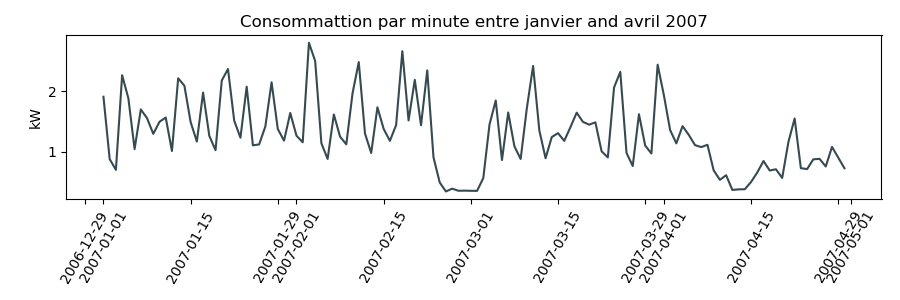

In [34]:
fig_2007_day = plt.figure(figsize=(9, 3))
ts_2007_day = ts_2007.groupby(ts_2007.index.date).mean()
plt.xticks(rotation=60)
plt.ylabel('kW')
plt.title("Consommattion par minute entre janvier and avril 2007")
plt.plot(ts_2007_day['Global_active_power'])
plt.tight_layout()
plt.show()

Les dates avec des creux semblent coïncider avec les vacances scolaires 2007, cf. http://cache.media.education.gouv.fr/file/83/6/5836.pdf

<IPython.core.display.Javascript object>


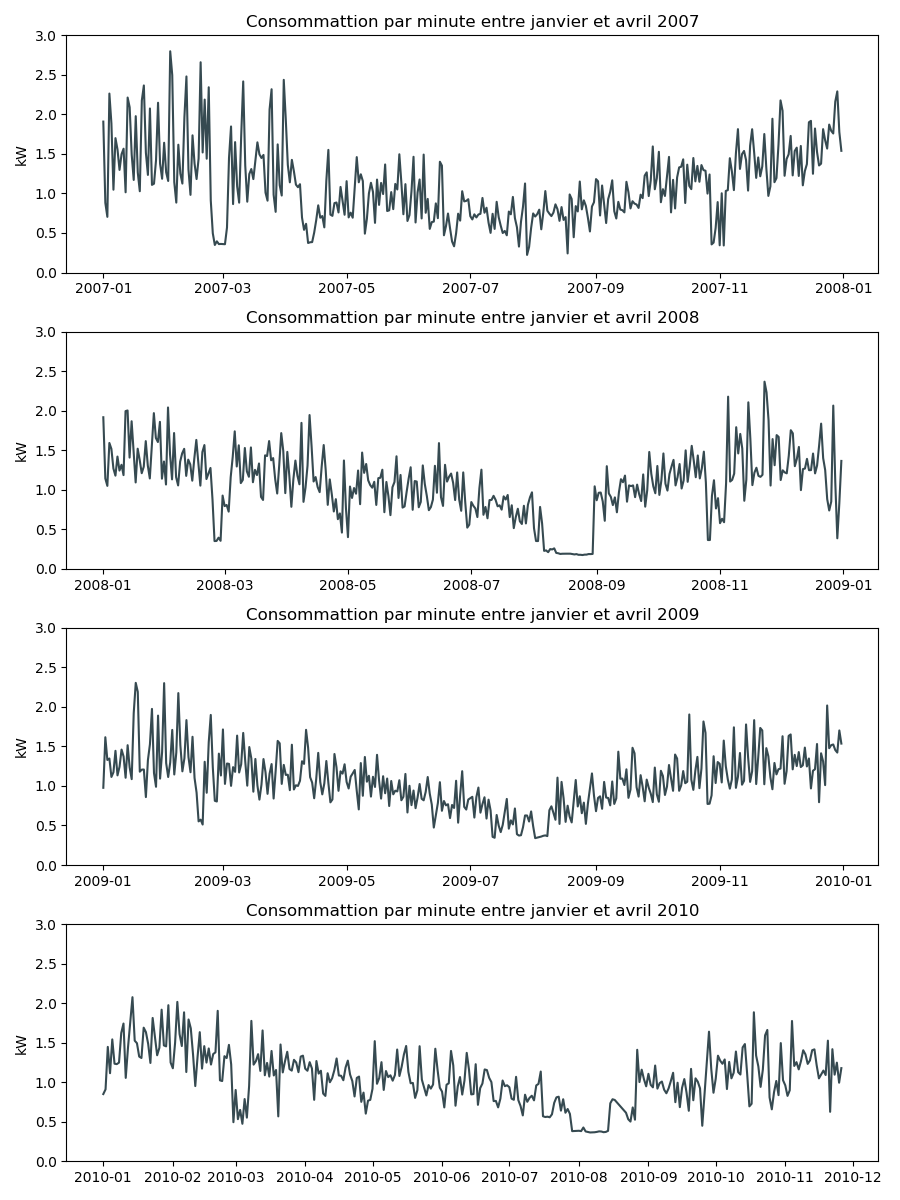

In [35]:
years = ['2007', '2008', '2009', '2010']
fig_fix1, axs = plt.subplots(4, 1, figsize=(9, 12))
axs = axs.ravel()
ts_years = []
for i, year in enumerate(years):
    day_ini = '01/01/' + year
    day_end = '31/12/' + year
    ts_year = ts_conso.loc[day_ini:day_end]
    ts_year_day = ts_year.groupby(ts_year.index.date).mean()
    ts_years.append(ts_year_day)
    axs[i].plot(ts_year_day)
    axs[i].set_ylim(0,3)
    axs[i].set_ylabel('kW')
    axs[i].set_title(
        "Consommattion par minute entre janvier et avril " + year)
plt.tight_layout()
plt.show()

## Analyse intra day : semaine vs. weekend
- profils journalier [semaine]

In [36]:
ts_conso['weekday'] = ts_conso.index.weekday  # Monday=0, Sunday=6
days = ['Lundi', 'Mardi', 'Mercredi',
        'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
ts_conso['weekend'] = ts_conso['weekday'].isin([5, 6])
ts_conso['workday'] = ts_conso['weekday'].isin([0, 1, 2, 3, 4])

ts_conso_full_week = ts_conso.groupby(['weekday', ts_conso.index.hour])[
    'Global_active_power'].mean().unstack(level=0)
ts_conso_full_week.columns=days

<IPython.core.display.Javascript object>


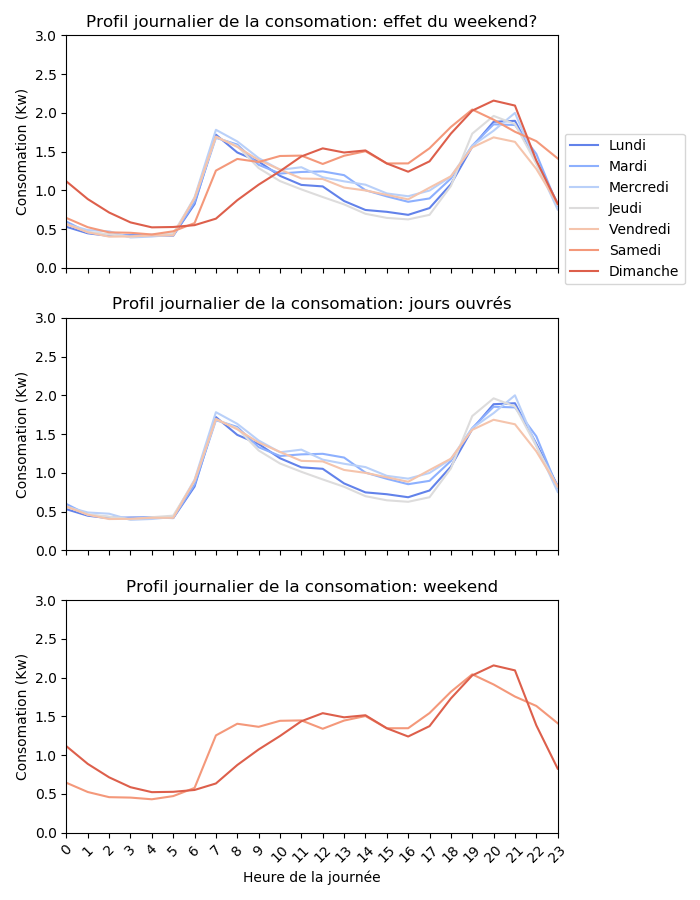

In [37]:
sns.set_palette("coolwarm", n_colors=7)
palette = sns.color_palette("coolwarm", 7)

listes_days =[days, ['Lundi', 'Mardi', 'Mercredi',
        'Jeudi', 'Vendredi'], ['Samedi', 'Dimanche']]
listes_days_titles = ['effet du weekend?', 'jours ouvrés', 'weekend']
color_palettes = [palette[0:7],palette[0:5],palette[5:7]]

fig, axes = plt.subplots(3, 1, figsize=(7,9), sharex=True)

for i, days_list in enumerate(listes_days):
    ts_conso_full_week[days_list].plot(ax=axes[i],color=color_palettes[i])
    axes[i].set_ylabel("Consomation (Kw)")
    axes[i].set_xlabel("Heure de la journée")
    axes[i].set_title("Profil journalier de la consomation: {}".format(listes_days_titles[i]))
    axes[i].set_xticks(np.arange(0,24))
    axes[i].set_xticklabels(np.arange(0,24),rotation=45)
    axes[i].set_ylim(0,3)
    axes[i].legend().set_visible(False)

axes[0].legend(labels=days,loc='lower left', bbox_to_anchor=(1, -0.10))
plt.tight_layout()

# Impact des saisons

<IPython.core.display.Javascript object>


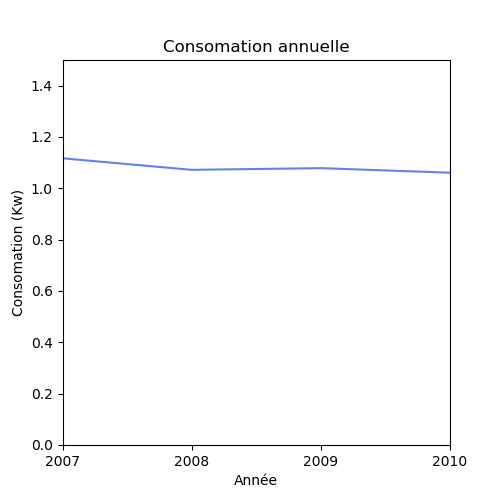

(0, 1.5)

In [38]:
plt.figure(figsize=(7, 7))
ax = ts_conso['Global_active_power'].resample('A').mean().plot(
    figsize=(5, 5))  # échantillone par année (A pour Annual)
ax.set_ylabel("Consomation (Kw)")
ax.set_xlabel("Année")
ax.set_title("Consomation annuelle")
ax.set_ylim(0, 1.5)

# Question :
- profils mensuel [semaine] ;


<IPython.core.display.Javascript object>


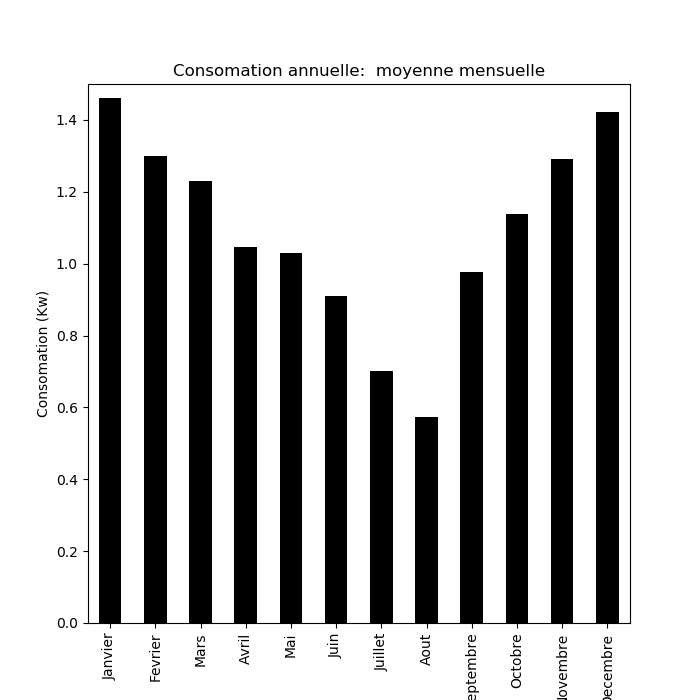

(0, 1.5)

In [39]:
sns.set_palette("GnBu_d", n_colors=9)
ts_conso['month'] = ts_conso.index.month
ts_conso_month = ts_conso.groupby('month').aggregate(np.mean)
mois = ['Janvier', 'Fevrier', 'Mars', 'Avril', 'Mai', 'Juin',
        'Juillet', 'Aout', 'Septembre', 'Octobre', 'Novembre', 'Decembre']

plt.figure(figsize=(7, 7))
ax = ts_conso_month['Global_active_power'].plot(kind='bar', color='k')
# ax = ts_conso['Global_active_power'].resample('M').mean().plot(figsize=(5,5))  # échantillone par année (A pour Annual)
ax.set_ylabel("Consomation (Kw)")
ax.set_xlabel("Année")
ax.set_title("Consomation annuelle:  moyenne mensuelle")
ax.set_xticklabels(mois)
ax.set_ylim(0, 1.5)

## Question:
Pour chaque groupe, calculer la moyenne par mois, et visualiser les variations moyenne


<IPython.core.display.Javascript object>


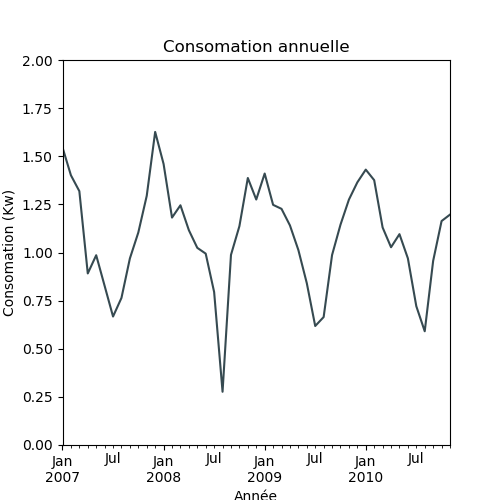

(0, 2)

In [40]:

plt.figure(figsize=(7, 7))
ax = ts_conso['Global_active_power'].resample('M').mean().plot(
    figsize=(5, 5))  # échantillone par année (A pour Annual)
ax.set_ylabel("Consomation (Kw)")
ax.set_xlabel("Année")
ax.set_title("Consomation annuelle")
ax.set_ylim(0, 2)

<IPython.core.display.Javascript object>


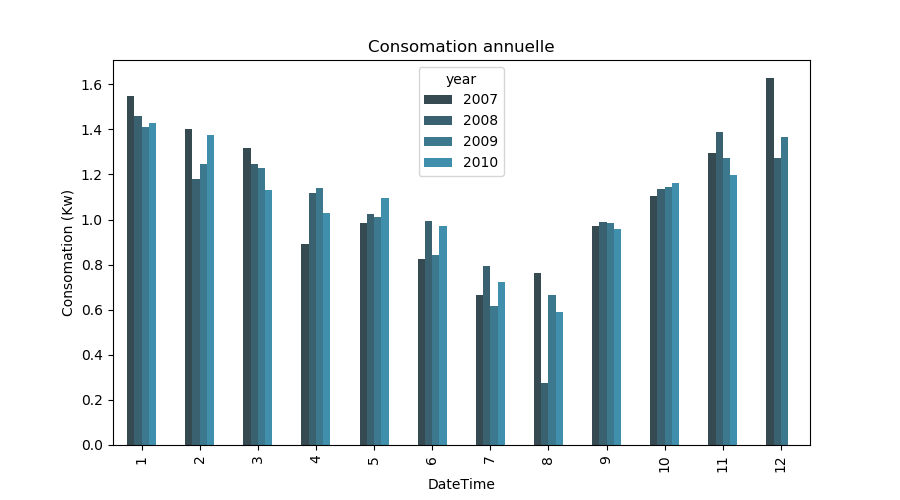

In [41]:
ts_conso['year'] = ts_conso.index.year
months = ['Janvier', 'Fevrier', 'Mars', 'Avril', 'Mai', 'Juin',
          'Juillet', 'Aout', 'Septembre', 'Octobre', 'Novembre', 'Decembre']
ts_conso_year = ts_conso.groupby(['year', ts_conso.index.month])[
    'Global_active_power'].mean().unstack(level=0)

ax = ts_conso_year.plot(kind='bar', figsize=(9, 5))
ax.set_ylabel("Consomation (Kw)")
ax.set_title("Consomation annuelle")
plt.show()

In [42]:
# TODO: Calculer correlation temperature  / conso. 

<a id="climat"> </a>
# Ajout de la température

In [43]:
url = "http://josephsalmon.eu/enseignement/TELECOM/MDI720/datasets/TG_STAID011249.txt"
path_target = "./TG_STAID011249.csv"
download(url, path_target, replace=False)

Replace is False and data exists, so doing nothing. Use replace==True to re-download the data.


'./TG_STAID011249.csv'

In [44]:
colnames = ['    DATE', '   TG']
temp_df = pd.read_csv('TG_STAID011249.csv', sep=',', comment='#',
                      usecols=colnames, na_values="-9999")
# note that NAN are coding with values -9999
temp_df.columns = ['Date', 'Temperature']
# need to get the correct temperature unit
temp_df['Temperature'] = temp_df['Temperature'] / 10.

In [45]:
temp_df.head()

,Date,Temperature
0,19210301,5.0
1,19210302,4.6
2,19210303,4.6
3,19210304,3.1
4,19210305,9.5


# Format de date à traiter:

In [46]:
temp_df['Date'] = pd.to_datetime(temp_df['Date'], format='%Y%m%d')
temp_ts = temp_df.set_index(['Date'])
temp_ts_2007 = temp_ts.loc[day_ini_2007:day_end_2007]

<IPython.core.display.Javascript object>


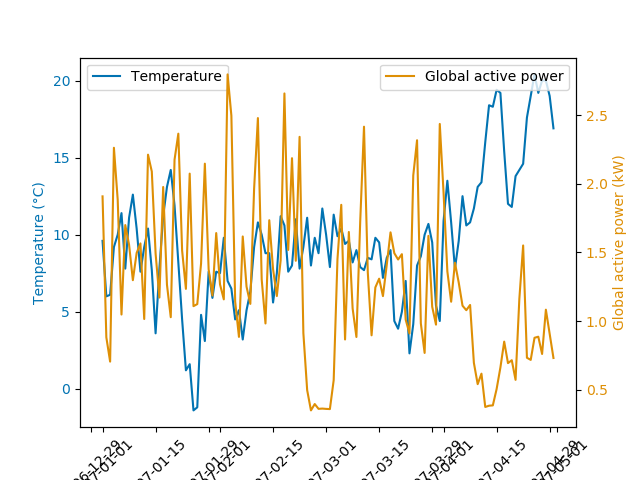

In [47]:
sns.set_palette("colorblind")
color_blind_list = sns.color_palette("colorblind", 8)

fig, ax1 = plt.subplots()
ax1.plot(temp_ts_2007, '-', color=color_blind_list[0], label='Temperature')

ax1.set_xlabel('time (s)')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Temperature (°C)', color=color_blind_list[0])

for tl in ax1.get_yticklabels():
    tl.set_color(color_blind_list[0])
plt.legend()

plt.xticks(rotation=45)

ax2 = ax1.twinx()
ax2.plot(ts_2007_day, '-', color=color_blind_list[1], label='Global active power')
ax2.set_ylabel('Global active power (kW)', color=color_blind_list[1])
for tl in ax2.get_yticklabels():
    tl.set_color(color_blind_list[1])
plt.legend()
plt.show()